# 3. Прогнозирование ряда со сложной сезонностью

In [3]:
from sklearn import linear_model
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
import itertools
import warnings
%pylab inline

MIN_FN = 15 # Минимальный номер файла (апр. 2010)
MAX_FN = 88 # Максимальный номер файла (май 2016)
ZONE_N = 1231 # Выбираем ячейку со вторым по величине количеством поездок в мае 2016 г. (552503 поездки)

# Вычисление индекса ряда данных по дате
def calc_hour_id(date):
    min_y, min_m = calc_ym_by_file_number(MIN_FN)
    min_date = pd.Timestamp(year=min_y, month=min_m, day=1)
    date_delta = date-min_date
    return int(date_delta.total_seconds()/3600)

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


## 3.1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.

#### Загрузка ряда данных для ячейки 1231 с апреля 2010 по май 2016

In [4]:
zone_series = pd.Series()
for fn in np.arange(MIN_FN, MAX_FN+1):
    with open(os.path.join(DATA_PATH, 'dump{}.pkl'.format(fn)), 'rb') as dump_file: 
        aggregated_data = pickle.load(dump_file)
        new_series = pd.Series(aggregated_data[:, ZONE_N], index=build_hours_index(*calc_ym_by_file_number(fn)))
        zone_series = new_series.combine_first(zone_series)
zone_series.name='n_trips'
zone_series.index.name='Date'

#### Усреднение данных по годам, месяцам и дням недели для выявления сезонности

In [5]:
# Загрузка в DataFrame для последующей агрегации
zone_df = pd.DataFrame(zone_series).reset_index()
zone_df['Year'] = zone_df['Date'].apply(lambda d: pd.Timestamp(d.year, 6, 15))
zone_df['Year_Month'] = zone_df['Date'].apply(lambda d: pd.Timestamp(d.year, d.month, 15))
zone_df['Year_Month_Day'] = zone_df['Date'].apply(lambda d: pd.Timestamp(d.year, d.month, d.day))
zone_df['Month'] = zone_df['Date'].apply(lambda d: d.month)
zone_df['Day_Of_Week'] = zone_df['Date'].apply(lambda d: d.dayofweek)
zone_df['Hour'] = zone_df['Date'].apply(lambda d: d.hour)

In [6]:
zone_df.head()

,Date,n_trips,Year,Year_Month,Year_Month_Day,Month,Day_Of_Week,Hour
0,2010-04-01 00:00:00,1122.0,2010-06-15,2010-04-15,2010-04-01,4,3,0
1,2010-04-01 01:00:00,621.0,2010-06-15,2010-04-15,2010-04-01,4,3,1
2,2010-04-01 02:00:00,385.0,2010-06-15,2010-04-15,2010-04-01,4,3,2
3,2010-04-01 03:00:00,236.0,2010-06-15,2010-04-15,2010-04-01,4,3,3
4,2010-04-01 04:00:00,283.0,2010-06-15,2010-04-15,2010-04-01,4,3,4


In [7]:
# Усреднение
zone_year = zone_df.groupby(by='Year')['n_trips'].mean()
zone_year_month = zone_df.groupby(by='Year_Month')['n_trips'].mean()
zone_year_month_day = zone_df.groupby(by='Year_Month_Day')['n_trips'].mean()
zone_month = zone_df.groupby(by='Month')['n_trips'].mean()
zone_day_of_week = zone_df.groupby(by='Day_Of_Week')['n_trips'].mean()
zone_hour = zone_df.groupby(by='Hour')['n_trips'].mean()

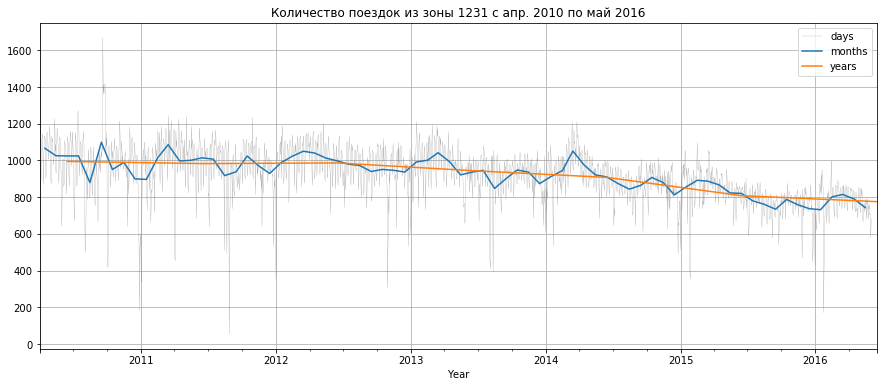

In [8]:
zone_year_month_day.plot(grid=True, figsize=(15,6), linewidth=0.2, color='gray', label='days', title='Количество поездок из зоны 1231 с апр. 2010 по май 2016')
zone_year_month.plot(grid=True, label='months')
zone_year.plot(grid=True, label='years')
plt.legend();

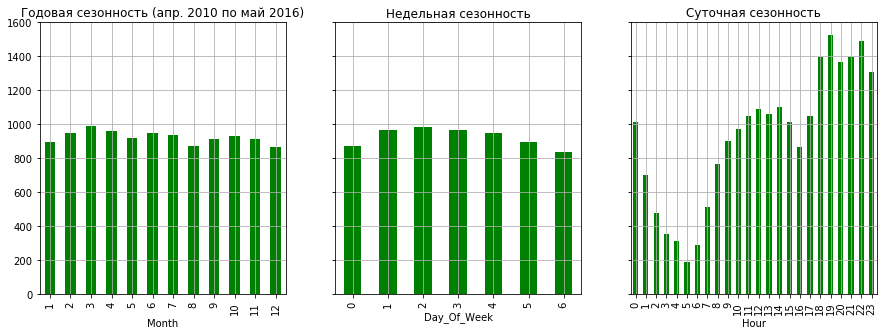

In [15]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True)
zone_month.plot(kind='Bar', title='Годовая сезонность (апр. 2010 по май 2016)', color='Green', grid=True, ax=axes[0]);
zone_day_of_week.plot(kind='Bar', title='Недельная сезонность', color='Green', grid=True, ax=axes[1]);
zone_hour.plot(kind='Bar', title='Cуточная сезонность', color='Green', grid=True, ax=axes[2]);

#### Далее для простоты ограничимся данными с янв. по май за 2016 г.

In [16]:
# Усреднение
zone_2016_df = zone_df[(zone_df.Date<=pd.Timestamp(2016,5,31)) & (zone_df.Date>=pd.Timestamp(2016,1,1))]
zone_series_2016 = pd.Series(zone_2016_df.n_trips.values, index=zone_2016_df.Date)
zone_2016_month = zone_2016_df.groupby(by='Year_Month')['n_trips'].mean()
zone_2016_month_day = zone_2016_df.groupby(by='Year_Month_Day')['n_trips'].mean()
zone_2016_day_of_week = zone_2016_df.groupby(by='Day_Of_Week')['n_trips'].mean()
zone_2016_hour = zone_2016_df.groupby(by='Hour')['n_trips'].mean()

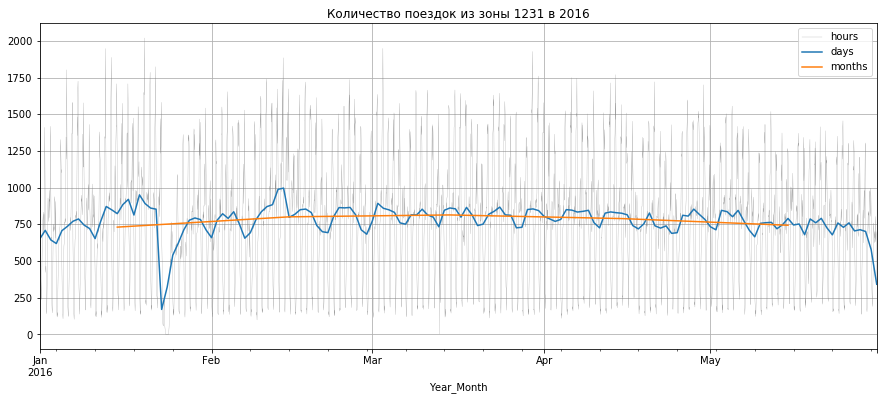

In [18]:
zone_series_2016.plot(grid=True, figsize=(15,6), linewidth=0.2, color='gray', label='hours', title='Количество поездок из зоны 1231 в 2016')
zone_2016_month_day.plot(grid=True, label='days')
zone_2016_month.plot(grid=True, label='months')
plt.legend();

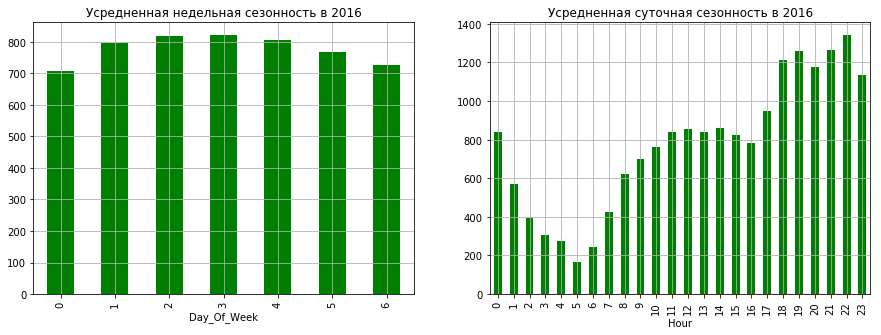

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
zone_2016_day_of_week.plot(kind='Bar', title='Усредненная недельная сезонность в 2016', color='Green', grid=True, ax=axes[0]);
zone_2016_hour.plot(kind='Bar', title='Усредненная суточная сезонность в 2016', color='Green', grid=True, ax=axes[1]);

#### Построение признаков для регрессии (недельной сезонности)

In [22]:
target = zone_series_2016
features = pd.DataFrame(index=target.index)
features['linear'] = np.arange(len(target))
for i in np.arange(1,5):
    features['weekly_sin_{}'.format(i)] = np.sin(np.arange(len(target))*2*np.pi*i/168)
    features['weekly_cos_{}'.format(i)] = np.cos(np.arange(len(target))*2*np.pi*i/168)

In [23]:
features.head()

,linear,weekly_sin_1,weekly_cos_1,weekly_sin_2,weekly_cos_2,weekly_sin_3,weekly_cos_3,weekly_sin_4,weekly_cos_4
Date,,,,,,,,,
2016-01-01 00:00:00,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2016-01-01 01:00:00,1,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831
2016-01-01 02:00:00,2,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573
2016-01-01 03:00:00,3,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969
2016-01-01 04:00:00,4,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239


## 3.2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

#### Настроим регрессионную модель (на недельную сезонность)

score=0.03


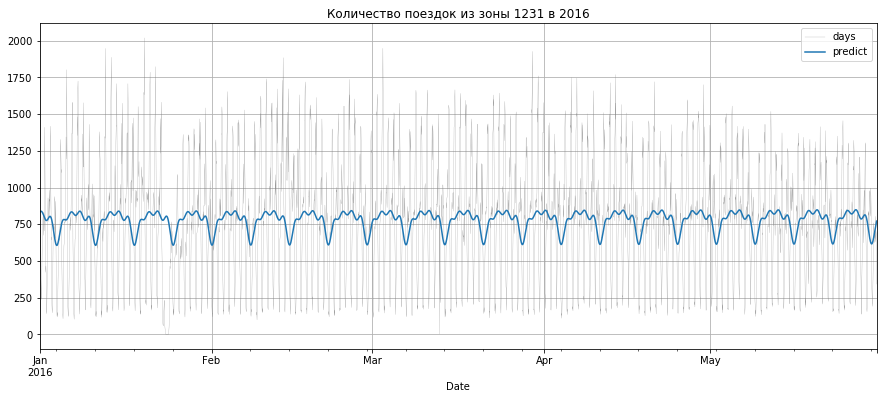

In [24]:
reg_model = linear_model.Lasso(random_state=0)
reg_model.fit(features, target)
predict = pd.Series(reg_model.predict(features), index=features.index)

score = reg_model.score(features, target)
print('score={:.2f}'.format(score))

zone_series_2016.plot(grid=True, figsize=(15,6), linewidth=0.2, color='gray', label='days', title='Количество поездок из зоны 1231 в 2016')
predict.plot(grid=True, label='predict')
plt.legend();

#### Посмотрим на остатки модели

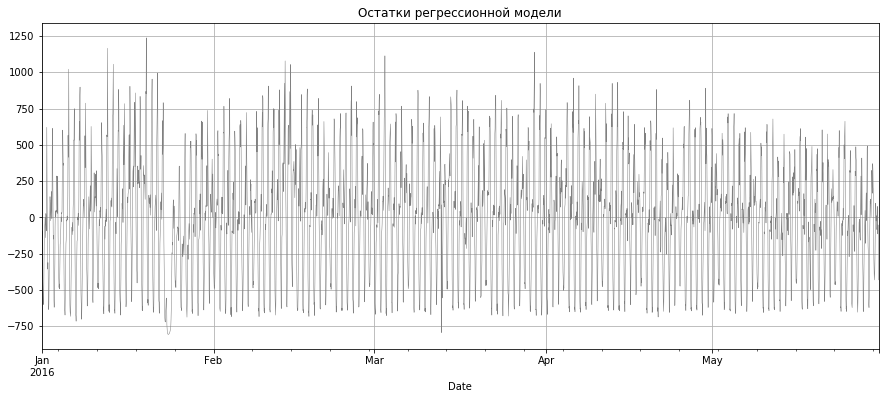

In [26]:
residual = zone_series_2016 - predict
residual.plot(grid=True, figsize=(15,6), linewidth=0.5, color='gray', label='hours', title='Остатки регрессионной модели')

#### Проверка стационарности и STL-декомпозиция остатков

Критерий Дики-Фуллера: p=1.13e-09


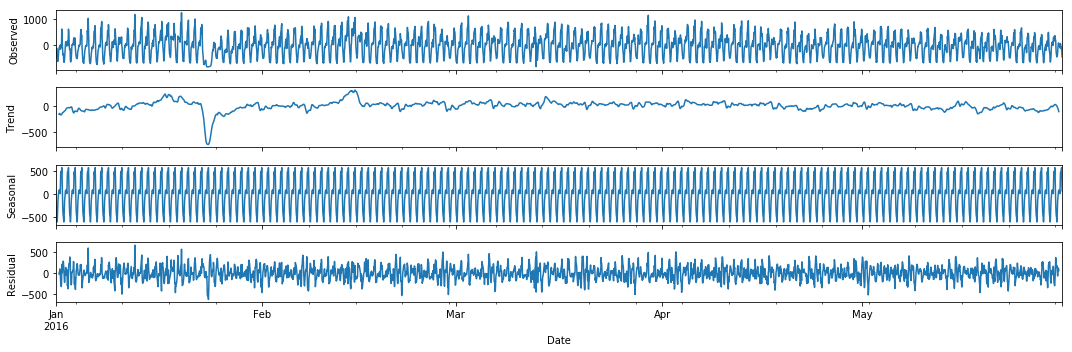

In [29]:
plt.figure(figsize(15,5))
sm.tsa.seasonal_decompose(residual).plot()
print('Критерий Дики-Фуллера: p={:.2e}'.format(sm.tsa.stattools.adfuller(residual)[1]))

Ряд остатков содержит как тренд, так и сезонную компоненту (и суточную и недельную). Гипотеза о нестационарности ряда критерием Дики-Фуллера не отвергается.

## 3.3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

#### Сделаем сезонное (суточное) дифференцирование

In [30]:
residual_dd = residual - residual.shift(24)

Критерий Дики-Фуллера: p=1.24e-21


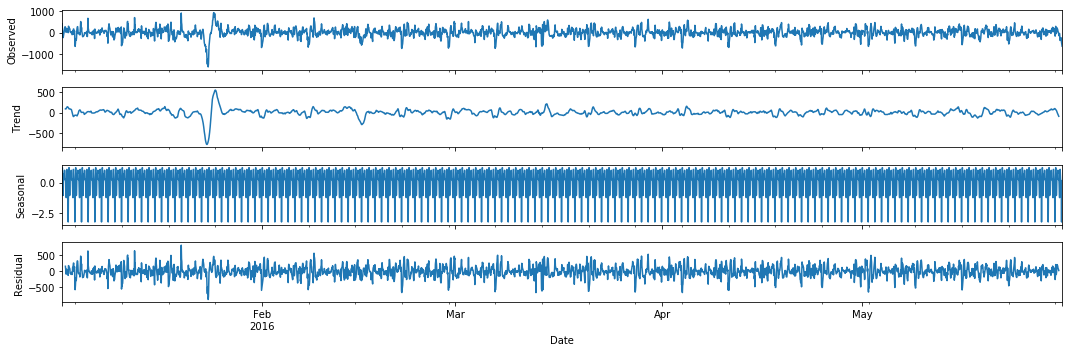

In [32]:
plt.figure(figsize(15,5));
sm.tsa.seasonal_decompose(residual_dd[24:]).plot();
print('Критерий Дики-Фуллера: p={:.2e}'.format(sm.tsa.stattools.adfuller(residual_dd[24:])[1]))

Уровень значимости Дики-Фуллера уменьшается, но ряд визуально становится лучше. Сезонность практически ушла.

#### Сделаем обычное дифференцирование

In [33]:
residual_dd_d = residual_dd - residual_dd.shift(1)

Критерий Дики-Фуллера: p=0.00e+00


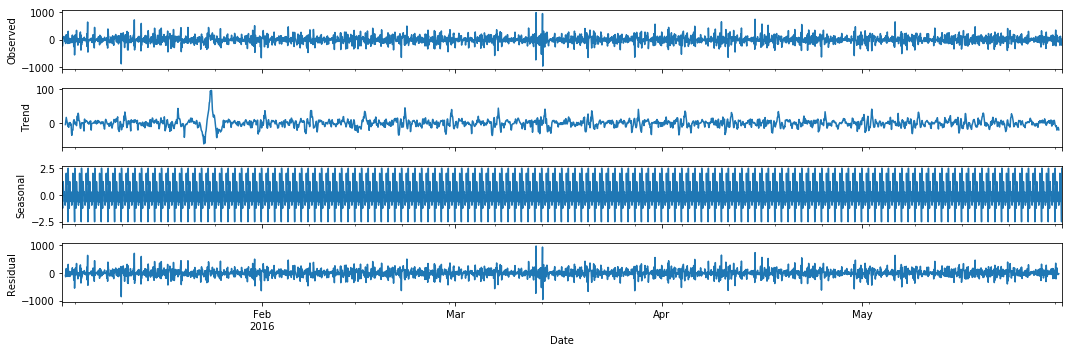

In [34]:
plt.figure(figsize(15,5));
sm.tsa.seasonal_decompose(residual_dd_d[25:]).plot();
print('Критерий Дики-Фуллера: p={:.2e}'.format(sm.tsa.stattools.adfuller(residual_dd_d[25:])[1]))

Уровень значимости Дики-Фуллера еще умньшается. Визуального улучшения ряда также не наблюдается. Далее будем использовать только сезонное (суточное) дифференцирование.

## 3.4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p, q, P, Qp,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

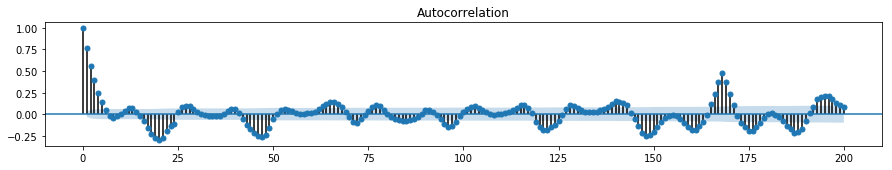

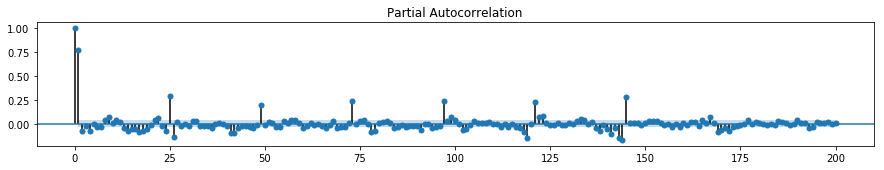

In [52]:
plt.figure(figsize(15,5))
sm.graphics.tsa.plot_acf(residual_dd[24:].values.squeeze(), lags=200, ax=plt.subplot(211))
pylab.show()
sm.graphics.tsa.plot_pacf(residual_dd[24:].values.squeeze(), lags=200, ax=plt.subplot(212))
pylab.show()

Начальные приближения параметров: p=1, P=6, q=5, Q=2

In [53]:
d=0
D=1
ps = [1]
Ps = [4,6]
qs = [3,5]
Qs = [1,2]
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

#### Подбор модели SARIMAX (для скорости возьмем данные за последний месяц)

In [54]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(residual[-24*30:], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    else:
        print(param, best_aic)
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(1, 3, 4, 1) inf
(1, 3, 4, 2) 8278.690153767635
(1, 3, 6, 1) 8277.748732191954
(1, 3, 6, 2) 8186.215985908867
(1, 5, 4, 1) 8186.215985908867
(1, 5, 4, 2) 8186.215985908867
(1, 5, 6, 1) 8186.215985908867
(1, 5, 6, 2) 8184.005745367552
Wall time: 1h 7min 21s


In [55]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters          aic
6  (1, 5, 6, 1)  8184.005745
7  (1, 5, 6, 2)  8185.880412
2  (1, 3, 6, 1)  8186.215986
3  (1, 3, 6, 2)  8189.366953
1  (1, 3, 4, 2)  8277.748732


## 4.5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов KK или поменять порядки дифференцирования.

In [56]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(1, 0, 5)x(6, 1, 1, 24)   Log Likelihood               -4078.003
Date:                            Sun, 08 Jul 2018   AIC                           8184.006
Time:                                    21:43:15   BIC                           8248.115
Sample:                                05-01-2016   HQIC                          8208.756
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4127      0.215      1.921      0.055      -0.008       0.834
ma.L1          0.3686      0.217   

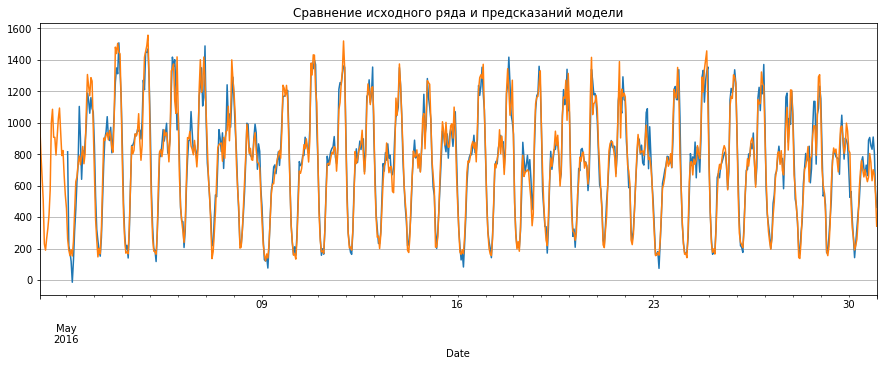

In [72]:
(best_model.fittedvalues[24:]+predict[-24*29:]).plot(grid=True, title='Сравнение исходного ряда и предсказаний модели')
zone_series_2016[-24*30:].plot(grid=True)

In [70]:
print('Коэффициент детерминации модели: {:.2f}'.format(
    metrics.r2_score(zone_series_2016[-24*29:], best_model.fittedvalues[24:]+predict[-24*29:])))

Коэффициент детерминации модели: 0.93


## 4.6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

На выбранном временном периоде (май 2016 г.) построенная модель удовлетворительно описывает данные.

# 2. Работа с геоданными

In [41]:
# Загрузка агрегированных данных о поездках в мае 2016
with open(os.path.join(DATA_PATH, 'dump88.pkl'), 'rb') as dump_file: aggregated_data = pickle.load(dump_file)

In [42]:
# Загрузка в DataFrame общего количества поездок из каждой зоны в мае 2016 г.
df = pd.DataFrame([calc_lon_lat(rid) for rid in range(2500)], columns=['lon', 'lat'])
df['n_trips'] = aggregated_data.sum(axis=0)

In [45]:
# Количество ячеек, из которых не было поездок в мае 2016 г.
len(df[df['n_trips']==0])

1283

In [46]:
# Оставляем только ячейки, из которых были поездки
df = df[df['n_trips']>0]
df['log10_trips'] = df['n_trips'].apply(np.log10)

In [47]:
df.head()

,lon,lat,n_trips,log10_trips
14,-74.250034,40.617749,1,0.000000
15,-74.250034,40.626137,1,0.000000
24,-74.250034,40.701631,1,0.000000
26,-74.250034,40.718407,1,0.000000
31,-74.250034,40.760348,19,1.278754


### Статическая карта

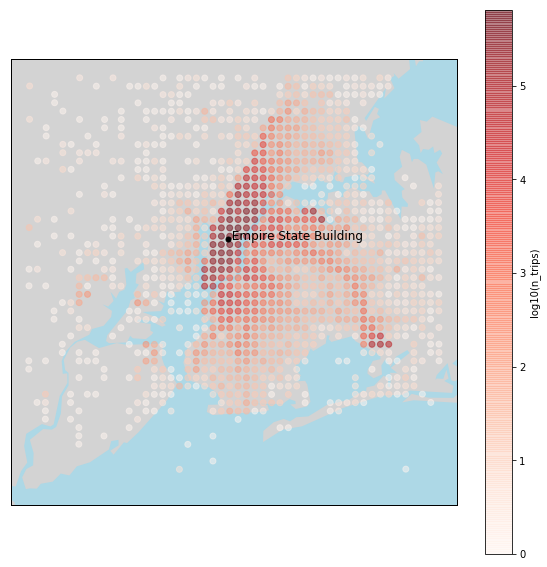

In [14]:
static_map(df)

### Интерактивная карта

In [26]:
interacitve_map(df)

Figure(layout=FigureLayout(height='420px'))

In [17]:
# Отфильтруем ячейки, из которых выполняется меньше 5 поездок в час - осталось 102 ячеек
df[df['n_trips']>=5*24*31].sort_values(by='n_trips')

,lon,lat,n_trips,log10_trips
1220,-73.983356,40.668078,3752,3.574263
1440,-73.938909,40.835842,3781,3.577607
1629,-73.894463,40.743572,3839,3.584218
1224,-73.983356,40.701631,3991,3.601082
1732,-73.872240,40.768736,4033,3.605628
1579,-73.905575,40.743572,4063,3.608847
1425,-73.938909,40.710019,4091,3.611829
1171,-73.994467,40.676466,4914,3.691435
1377,-73.950021,40.726795,5244,3.719663
1441,-73.938909,40.844230,5252,3.720325


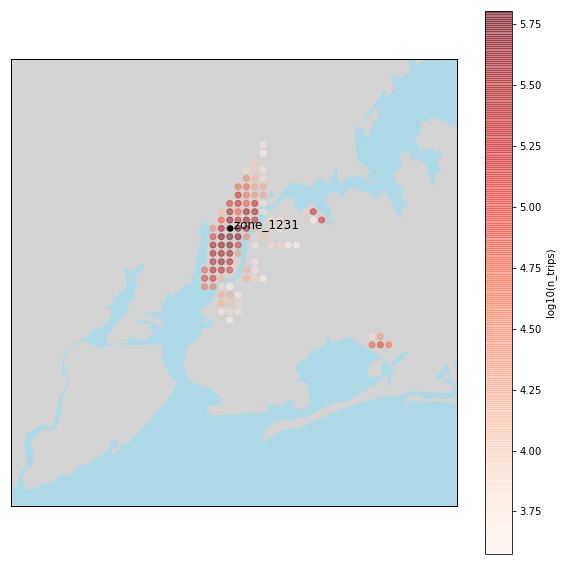

In [22]:
static_map(df[df['n_trips']>=5*24*31], (*calc_lon_lat(1231), ' zone_1231'))

In [16]:
interacitve_map(df[df['n_trips']>=5*24*31])

Figure(layout=FigureLayout(height='420px'))

In [ ]:
# ВЫВОД: среди оставшихся нет ячеек, из которых поездки невозможны

# 1. Знакомство с данными и агрегация

In [789]:
# Анализ заголовков таблиц по всему объему данных
with open("dump_columns.pkl", 'rb') as dump_file: columns = pickle.load(dump_file)
df = pd.DataFrame(row[1].decode('utf-8').split(',') for row in columns)
df['ind'] = range(107, -1, -1)
df['url'] = [row[0] for row in columns]
with pd.option_context('display.max_rows', 200):
    IPython.display.display(df.iloc[:,[5,-2,-1]])

# Выяснилось, что с июля 2016 г. формат записи меняется (вместо широты и долготы указывается идентификатор зоны)
# Кроме того, заголовки столбцов отличаются в разные месяцы (нужно извлекать данные не по заголовку столбца, а по порядковому номеру)

,5,ind,url
0,RatecodeID,107,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-12.csv
1,RatecodeID,106,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-11.csv
2,RatecodeID,105,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-10.csv
3,RatecodeID,104,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-09.csv
4,RatecodeID,103,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-08.csv
5,RatecodeID,102,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-07.csv
6,RatecodeID,101,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-06.csv
7,RatecodeID,100,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-05.csv
8,RatecodeID,99,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-04.csv
9,RatecodeID,98,https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-03.csv


In [802]:
# Обработка данных за май 2016 г.
%%time
process_files(raw_data_paths)

START: 88 - data\yellow_tripdata_2016-05.csv
done: chunk 0, filtered: 17614/1000000
done: chunk 1, filtered: 17112/1000000
done: chunk 2, filtered: 16919/1000000
done: chunk 3, filtered: 18996/1000000
done: chunk 4, filtered: 18186/1000000
done: chunk 5, filtered: 17725/1000000
done: chunk 6, filtered: 19269/1000000
done: chunk 7, filtered: 18583/1000000
done: chunk 8, filtered: 16541/1000000
done: chunk 9, filtered: 17235/1000000
done: chunk 10, filtered: 17377/1000000
done: chunk 11, filtered: 14775/1000000
DONE: 88 - data\yellow_tripdata_2016-05.csv
Wall time: 9min 53s


In [ ]:
# Заготовка для обработки всего объема данных
start_time = pd.Timestamp.today()
f_stdout = open('f_stdout.txt', 'w')
orig_stdout = sys.stdout
sys.stdout = f_stdout
try:
    process_urls(raw_data_urls)
finally:
    sys.stdout = orig_stdout
    f_stdout.close()

In [733]:
with open("dump88.pkl", 'rb') as dump_file: aggregated_data = pickle.load(dump_file)

In [863]:
# Выводим часть агрегированной таблицы
# Столбцы соответствуют зонам, строки - часам с начала месяца
df = pd.DataFrame(aggregated_data, index=build_hours_index(2016, 5), columns=regions_index)
with pd.option_context('display.max_columns', 10, 'display.max_rows', 5):
    IPython.display.display(df)

,1,2,3,4,5,...,2496,2497,2498,2499,2500
2016-05-01 00:00:00,0,0,0,0,0,...,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,...,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31 22:00:00,0,0,0,0,0,...,0,0,0,0,0
2016-05-31 23:00:00,0,0,0,0,0,...,0,0,0,0,0


In [805]:
# Определяем номер ячейки, содержащей Empire State Building
calc_region_id(-73.985428, 40.748817)

1230

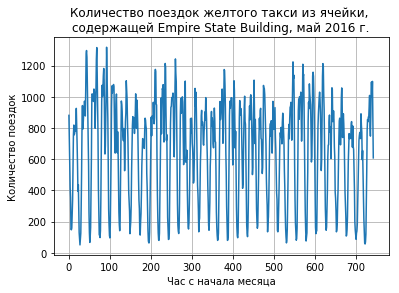

In [820]:
plt.xlabel('Час с начала месяца')
plt.ylabel('Количество поездок')
plt.title('Количество поездок желтого такси из ячейки, \nсодержащей Empire State Building, май 2016 г.')
plt.grid(True)
plt.plot(aggregated_data[:,1230])

In [892]:
# Количество пар час-ячейка, для которых не было ни одной поездки в мае 2016
empty_cell_n = np.sum(aggregated_data==0)
total_cells = np.prod(aggregated_data.shape)
empty_cell_n, total_cells, '{:.2f}'.format(empty_cell_n/total_cells)

(1718238, 1860000, '0.92')

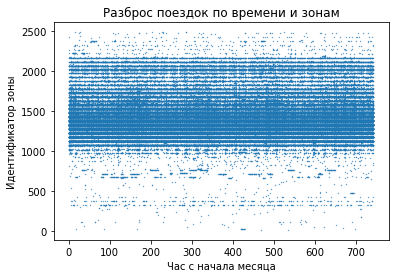

In [893]:
(x, y) = np.where(aggregated_data!=0)
plt.xlabel('Час с начала месяца')
plt.ylabel('Идентификатор зоны')
plt.title('Разброс поездок по времени и зонам')
plt.scatter(x, y, s=0.1)

# Импорт и общие определения

In [2]:
import numpy as np
import pandas as pd
import os
import IPython.display
import urllib.request
import sys
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

import os
import gmaps
gmaps.configure(api_key=os.environ['GOOGLE_API_KEY'])
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as patches
%matplotlib inline

DATA_PATH = 'data'

MIN_LAT, MAX_LAT = 40.49612, 40.91553 # Границы зоны
MIN_LON, MAX_LON = -74.25559, -73.70001
D_LAT, D_LON = (MAX_LAT - MIN_LAT)/50., (MAX_LON - MIN_LON)/50. # Шаг по широте и долготе
MEAN_LON, MEAN_LAT = np.mean((MIN_LON, MAX_LON)), np.mean((MIN_LAT, MAX_LAT)) # Центр зоны
ESB_LON, ESB_LAT = -73.985428, 40.748817 # Empire State Building
SL_LON, SL_LAT = -74.043670, 40.691641 # Статуя Свободы

CHUNK_SIZE = 10**6
MIN_YEAR = 2009

# Список загруженных файлов
raw_data_paths = [(2016, 5, (2016-MIN_YEAR)*12+5-1, os.path.join(DATA_PATH, 'yellow_tripdata_2016-05.csv'))]
# Список ссылок со всем объемом данных
raw_data_urls = [(y, m, (y-MIN_YEAR)*12+m-1, "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_{}-{:0>2}.csv".format(y, m))
                 for y in range(2017, 2008, -1) for m in range(12, 0, -1)]

# Список идентификаторов зон (начинается с 1)
regions_index = np.arange(2500)+1

# Интерактивная карта
def interacitve_map(data):
    fig=gmaps.figure(center=(MEAN_LAT, MEAN_LON), zoom_level=9)
    polygon = gmaps.Polygon([(MIN_LAT, MIN_LON), (MIN_LAT, MAX_LON), (MAX_LAT, MAX_LON), (MAX_LAT, MIN_LON)])
    drawing_layer = gmaps.drawing_layer([polygon], mode='DISABLED')
    heatmap_layer = gmaps.heatmap_layer(
        data[['lat', 'lon']],
        weights=data['log10_trips'],
        dissipating=False,
        point_radius=0.005,
        max_intensity=3
    )
    marker_layer = gmaps.marker_layer([(SL_LAT, SL_LON)], label=['Статуя Свободы'])
    fig.add_layer(drawing_layer)
    fig.add_layer(heatmap_layer)
    fig.add_layer(marker_layer)
    return fig

# Статическая карта
def static_map(data, label=(ESB_LON, ESB_LAT, ' Empire State Building')):
    plt.figure(figsize=(10, 10))

    m = Basemap(width=50000, height=50000, lat_0=(MIN_LAT+MAX_LAT)/2, lon_0=(MIN_LON+MAX_LON)/2,
                projection='gnom', resolution='h')

    m.drawmapboundary(fill_color='lightblue')
    m.fillcontinents(color='lightgrey', lake_color='lightblue')

    L_LON, L_LAT, L_TXT = label
    
    minx, miny = m(MIN_LON, MIN_LAT)
    maxx, maxy = m(MAX_LON, MAX_LAT)
    esbx, esby = m(L_LON, L_LAT)

    plt.plot(esbx, esby, 'ok', markersize=5)
    plt.text(esbx, esby, L_TXT, fontsize=12);
    m.scatter(data['lon'].values, data['lat'].values, latlon=True, 
              c=data['log10_trips'].values, alpha=0.5, zorder=2, cmap=plt.get_cmap('Reds'))
    plt.colorbar(label='log10(n_trips)');

# Вычисление номера файла по году и месяцу
def calc_file_number(y, m):
    return (y-MIN_YEAR)*12+m-1

# Вычисление года и месяца по ноеру файла
def calc_ym_by_file_number(fn):
    return (fn//12+MIN_YEAR, fn%12+1)

# Вычисление широты и долготы центра по номеру зоны
def calc_lon_lat(region_id):
    row = region_id//50+0.5
    col = region_id%50+0.5
    return (MIN_LON + row*D_LON, MIN_LAT+col*D_LAT)

# Список временных меток по часам с начала месяца
def build_hours_index(y, m):
    return pd.DatetimeIndex(start=pd.Timestamp(year=y, month=m, day=1), freq='h', periods=744)

# Загрузка первой строки (заголовков таблицы) файла по ссылке url
def download_columns(url):
    with urllib.request.urlopen(url) as stream: return(stream.readline())

# Извлечение временной метки отправления из строки файла данных
def get_pickup_datetime(row):
    return pd.Timestamp(row[1])

# Извлечение временной метки прибытия из строки файла данных
def get_dropoff_datetime(row):
    return pd.Timestamp(row[2])

# Извлечение количества пассажиров из строки файла данных
def get_passenger_count(row):
    return int(row[3])

# Извлечение дальности поездки из строки файла данных
def get_trip_distance(row):
    return float(row[4])

# Извлечение долготы отправления из строки файла данных
def get_pickup_lon(row, file_i):
    if file_i>=90: return np.nan
    else: return float(row[5])
    
# Извлечение долготы отправления из строки файла данных
def get_pickup_lat(row, file_i):
    if file_i>=90: return np.nan
    else: return float(row[6])

# Извлечение зоны отправления из строки файла данных
# ! Индекс региона на 1 меньше, чем в файле regions.csv
def get_region_id(row, file_i):
    if file_i>=90: return int(row[7])-1
    else: return np.nan
    
# Вычисление индекса зоны по долготе и широте
# ! Индекс региона на 1 меньше, чем в файле regions.csv
def calc_region_id(lon, lat):
    return int(50*np.floor((lon-MIN_LON)/D_LON) + np.floor((lat-MIN_LAT)/D_LAT))

# Извлечение зоны отправления из строки файла данных
def calc_pickup_region(row, file_i):
    if file_i>=90: return int(row[7])
    else: return calc_region_id(float(row[5]), float(row[6]))

# Вычисление индексов агрегированного массива для обработки строки файла данных
def calc_indices(row, file_i):
    pu_datetime = get_pickup_datetime(row)
    # Порядковый номер часа с начала месяца (начинается с 0)
    hour_id = (pu_datetime.day-1)*24 + pu_datetime.hour
    region_id = calc_pickup_region(row, file_i)
    return (hour_id, region_id)

# Проверка строки файла данных на ошибки и аномалии
def check_data_row(row, file_i):
    try:
        if file_i>=90: # с июля 2016
            return ((get_dropoff_datetime(row) > get_pickup_datetime(row)) 
                    and (get_trip_distance(row) > 0)
                    and (get_passenger_count(row) > 0) 
                    and (get_region_id(row, file_i) < 2500)
                   )
        else: # до июля 2016
            return ((get_dropoff_datetime(row) > get_pickup_datetime(row)) # с ненулевой длительностью
                    and (get_trip_distance(row) > 0) # с ненулевым расстоянием
                    and (get_passenger_count(row) > 0) # с ненулевым количеством пассажиров
                    and (get_pickup_lon(row, file_i) > MIN_LON) # попадают в прямоугольник Нью-Йорка
                    and (get_pickup_lon(row, file_i) < MAX_LON)
                    and (get_pickup_lat(row, file_i) > MIN_LAT)
                    and (get_pickup_lat(row, file_i) < MAX_LAT)
                   )
    except:
        return False

# Агрегирование файла (потока) данных
def process_stream(stream, file_i):
    # По строкам - порядковые номера часов с начала месяца (всего 31*24)
    # По столбцам - идентификаторы зон
    aggregated_data = np.zeros((744, 2500), dtype=np.uint16)
    # Читаем файл кусками по SHUNK_SIZE строк, не загружая в память целиком
    reader = pd.read_csv(stream, chunksize=CHUNK_SIZE)
    for (chunk_i, chunk) in enumerate(reader):
        filtered_n = 0
        print("loaded: chunk {}, {}".format(chunk_i, pd.Timestamp.today()-start_time))
        f_stdout.flush()
        for row in chunk.itertuples(index=False):
            if check_data_row(row, file_i):
                indices = calc_indices(row, file_i)
                aggregated_data[indices] += 1
            else: filtered_n += 1
        # Выводим сообщение о завершении обработки куска файла и количестве отфильтрованных строк
        print("done: chunk {}, filtered: {}/{}, {}".format(chunk_i, filtered_n, CHUNK_SIZE, pd.Timestamp.today()-start_time))
        f_stdout.flush()
    # Сохраняем агрегированный массив в файл
    with open("dump{}.pkl".format(file_i), 'wb') as dump_file: pickle.dump(aggregated_data, dump_file, protocol=2)

# Агрегирование списка файлов
def process_files(paths):
    for (y, m, file_i, path) in paths:
        print("START: {} - {}, {}".format(file_i, path, pd.Timestamp.today()-start_time))
        f_stdout.flush()
        with open(path, 'r') as stream: process_stream(stream, file_i)
        print("DONE: {} - {}, {}".format(file_i, path, pd.Timestamp.today()-start_time))
        f_stdout.flush()

# Агрегирование списка url
def process_urls(urls):
    for (y, m, file_i, url) in urls:
        print("START: {} - {}, {}".format(file_i, url, pd.Timestamp.today()-start_time))
        f_stdout.flush()
        with urllib.request.urlopen(url) as stream: process_stream(stream, file_i)
        print("DONE: {} - {}, {}".format(file_i, url, pd.Timestamp.today()-start_time))
        f_stdout.flush()